In [68]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad

from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats

from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi
from math import gamma as gamma_function
from math import factorial

from utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dx, x2z, x2z_dz

# import warnings
# warnings.filterwarnings('ignore')

## 2a) - simple BVP

In [69]:
eps = 0.1
x0, xN = 0, 1
g0, gN = 0, 0
# a, b, c = -eps, -1, -1
a, b, c = -eps, -1, 0

# def f(x): return np.zeros(x.shape[0])
def f(x): return np.ones(x.shape[0])

def u_exact_solution(x, eps=eps): return (np.exp(-x/eps) + (x - 1) - np.exp(-1/eps)*x)/(np.exp(-1/eps) - 1)

### Collocation - LCM (nodal)

In [75]:
alpha, beta = 0, 0 # Legendere polynomials
N = 20

# z are the points in [-1,1]
z = JacobiGL(alpha=alpha, beta=beta, N=N)
D_z = constructD(x=z, alpha=alpha, beta=beta)

x = z2x(z, x0, xN)

# du/dz = D u => du/dx dx/dz = D u => du/dx = (1 / (dx/dz)) D u
x2z_dz_value = x2z_dz(x0, xN)
D = x2z_dz_value * D_z

# in the slides there is a mistake, a is correct, -a is NOT correct
L_N = a * D @ D + b * D + c * np.eye(N+1)

L_N[0, :] = 0
L_N[0, 0] = 1

L_N[N, :] = 0
L_N[N, N] = 1

print(f"{L_N.shape = }")
print(f"{np.linalg.cond(L_N) = }")
# plt.spy(L_N)

fx = f(x).copy()
fx[0] = g0
fx[N] = gN

u = linalg.solve(L_N, fx)

L_N.shape = (21, 21)
np.linalg.cond(L_N) = np.float64(8513.884155252395)


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_86210/1044831797.py:15: RuntimeWarning: divide by zero encountered in matmul
  L_N = a * D @ D + b * D + c * np.eye(N+1)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_86210/1044831797.py:15: RuntimeWarning: overflow encountered in matmul
  L_N = a * D @ D + b * D + c * np.eye(N+1)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_86210/1044831797.py:15: RuntimeWarning: invalid value encountered in matmul
  L_N = a * D @ D + b * D + c * np.eye(N+1)


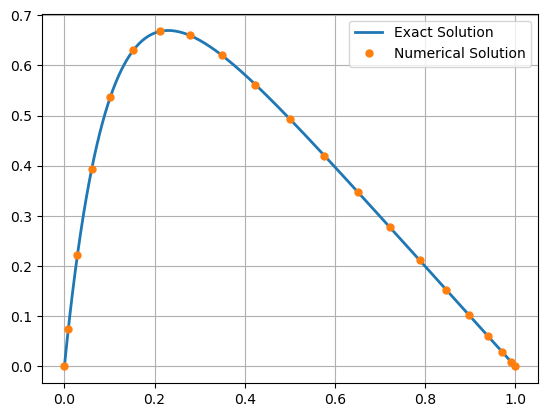

In [79]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

plt.plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
plt.plot(x, u, 'o', label="Numerical Solution", markersize=5)
plt.grid();
plt.legend();

/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/scipy/differentiate/_differentiate.py:537: RuntimeWarning: divide by zero encountered in matmul
  work.df[ic] = fc @ wc / work.h[ic]
/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/scipy/differentiate/_differentiate.py:537: RuntimeWarning: overflow encountered in matmul
  work.df[ic] = fc @ wc / work.h[ic]
/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/scipy/differentiate/_differentiate.py:537: RuntimeWarning: invalid value encountered in matmul
  work.df[ic] = fc @ wc / work.h[ic]


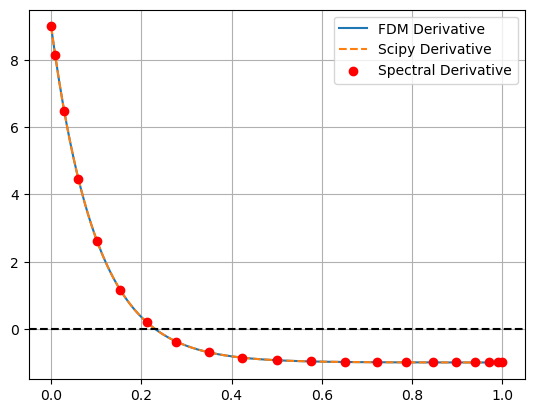

In [ ]:
h = np.median(np.diff(x_plot))
du_dx_fdm = (u_exact_plot[2:] - u_exact_plot[:-2])/(2*h)

from scipy.differentiate import derivative
res = derivative(u_exact_solution, x_plot)

du_dx_spectral = D @ u_exact_solution(x, eps)

plt.plot(x_plot[1:-1], du_dx_fdm, label="FDM Derivative");
plt.plot(x_plot, res.df, linestyle='--', label = "Scipy Derivative");
plt.scatter(x, du_dx_spectral, color='red', label="Spectral Derivative", zorder=5)
plt.axhline(0, color='k', linestyle='--')
plt.legend();
plt.grid();

### Tau - LTM (modal)

## 2b) - complex BVP, flow cylinder